 # Tutorial 2: Confined, Semiflexible Homopolymer
 
This tutorial follows from `tutorial_1` and will introduce the concept of confinement to the polymer model. The confinement is implemented as a hard spherical boundary. Descriptions of the model setup are included in `tutorial_1`. This notebook will highlight the addition required to implement the confinement.

#### Import Modules

In [1]:
# Built-in modules
import os
import sys

# Third-party modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Custom modules
from chromo.binders import get_by_name, make_binder_collection
from chromo.polymers import SSWLC
from chromo.fields import NullField
import chromo.mc as mc
import chromo.mc.mc_controller as ctrl
from chromo.util.reproducibility import get_unique_subfolder_name

#### Specify Binders

In [2]:
# Initialize a null binder to serve as a placeholder
null_binder = get_by_name("null_reader")

# Create a binder collection (required to run a simulation)
binder_collection = make_binder_collection([null_binder])

#### Specify the Confinement

We will specify a 2-nm radus spherical confinement. This is a highly confined system, in the context of our polymer.

In [3]:
confine_type = "Spherical"
confine_length = 2.0

#### Instantiate the Polymer

Since we are working in a confined system, we will instantiate the polymer as a random walk inside the confinement using the `confined_gaussian_walk` class method.

In [4]:
# Specify the name, number of beads, bead spacing, and persistence length of the polymer
name = "poly"
num_beads = 1000
bead_spacings = np.ones(num_beads - 1)
lp = 10

# Instantiate the polymer
poly = SSWLC.confined_gaussian_walk(
    name, num_beads, bead_spacings, lp=lp, confine_type=confine_type, confine_length=confine_length
)

No states defined.
No chemical modifications defined.


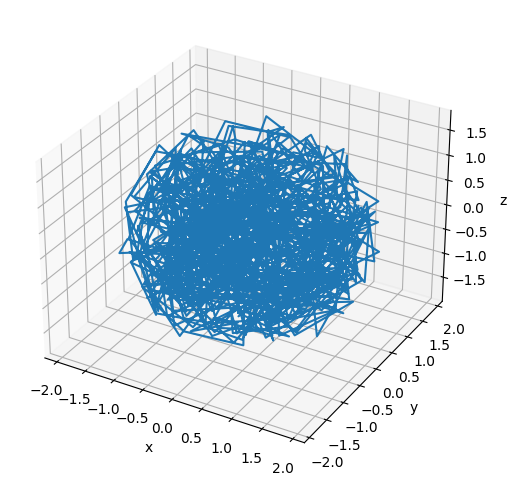

In [5]:
# Plot the initial configuration of the polymer
x = poly.r[:, 0]
y = poly.r[:, 1]
z = poly.r[:, 2]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.plot3D(np.asarray(x), np.asarray(y), np.asarray(z))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

#### Instantiate the Null Field

The field is responsible for enforcing the confinement. We need to specify the confinement when we instantiate the field.

In [6]:
field = NullField(
    polymers=[poly], confine_type=confine_type, confine_length=confine_length
)

#### Specify the Simulation Parameters

In [7]:
amp_bead_bounds, amp_move_bounds = mc.get_amplitude_bounds(
    polymers = [poly]
)

In [8]:
out_dir = "output_demo"
latest_sim = get_unique_subfolder_name(f"{out_dir}/sim_")
moves_to_use = ctrl.all_moves_except_binding_state(
    log_dir=latest_sim,
    bead_amp_bounds=amp_bead_bounds.bounds,
    move_amp_bounds=amp_move_bounds.bounds,
    controller=ctrl.SimpleControl
)

In [9]:
# Specify the number of snapshots and the number of MC steps to attempt per snapshot
num_snapshots = 200
mc_steps_per_snapshot = 1000

#### Run the Simulation

In [10]:
polymers = mc.polymer_in_field(
    polymers = [poly],
    binders = binder_collection,
    field = field,
    num_save_mc = mc_steps_per_snapshot,
    num_saves = num_snapshots,
    bead_amp_bounds = amp_bead_bounds,
    move_amp_bounds = amp_move_bounds,
    output_dir = out_dir,
    mc_move_controllers = moves_to_use
)

Save point 0 completed
Save point 1 completed
Save point 2 completed
Save point 3 completed
Save point 4 completed
Save point 5 completed
Save point 6 completed
Save point 7 completed
Save point 8 completed
Save point 9 completed
Save point 10 completed
Save point 11 completed
Save point 12 completed
Save point 13 completed
Save point 14 completed
Save point 15 completed
Save point 16 completed
Save point 17 completed
Save point 18 completed
Save point 19 completed
Save point 20 completed
Save point 21 completed
Save point 22 completed
Save point 23 completed
Save point 24 completed
Save point 25 completed
Save point 26 completed
Save point 27 completed
Save point 28 completed
Save point 29 completed
Save point 30 completed
Save point 31 completed
Save point 32 completed
Save point 33 completed
Save point 34 completed
Save point 35 completed
Save point 36 completed
Save point 37 completed
Save point 38 completed
Save point 39 completed
Save point 40 completed
Save point 41 completed
Sa

#### Analyze the Simulation

Again, we will analyze the simulation results by plotting the mean-squared end-to-end distances of the polymer. Notice, oscillations in the mean-squared end-to-end distance emerge as a result of the tight confinement.

In [11]:
# Load the simulation results
sim_dir = latest_sim

# Load and sort snapshots
snapshots = os.listdir(sim_dir)
snapshots = np.array([snap for snap in snapshots if snap.startswith("poly") and snap.endswith(".csv")])
snap_inds = np.array([int(snap.split("-")[-1].split(".")[0]) for snap in snapshots])
snapshots = snapshots[np.argsort(snap_inds)]
snap_inds = np.sort(snap_inds)

# Isolate equilibrated snapshots
num_equilibration_steps = 180
snapshots = snapshots[num_equilibration_steps:]

In [12]:
# Specify the segment lengths for which to calculate the end-to-end distances
bead_steps = np.arange(1, 100)
kuhn_steps = bead_steps / (2 * lp)

# Calculate the end-to-end distances for variable segment lengths along the polymer
mean_r2 = []
for i, snap in enumerate(snapshots):
    snap_path = os.path.join(sim_dir, snap)
    config = pd.read_csv(snap_path, sep=",", header=[0, 1], index_col=0)
    r = config["r"].to_numpy()
    mean_r2_snap = []
    for step in bead_steps:
        r1 = r[:-step]
        r2 = r[step:]
        delta_r = r2 - r1
        mean_end_to_end = np.average(np.linalg.norm(delta_r, axis=1) ** 2)
        mean_r2_snap.append(mean_end_to_end)
    mean_r2_snap = np.array(mean_r2_snap)
    mean_r2.append(mean_r2_snap)
mean_r2 = np.array(mean_r2)
mean_r2 = np.average(mean_r2, axis=0)

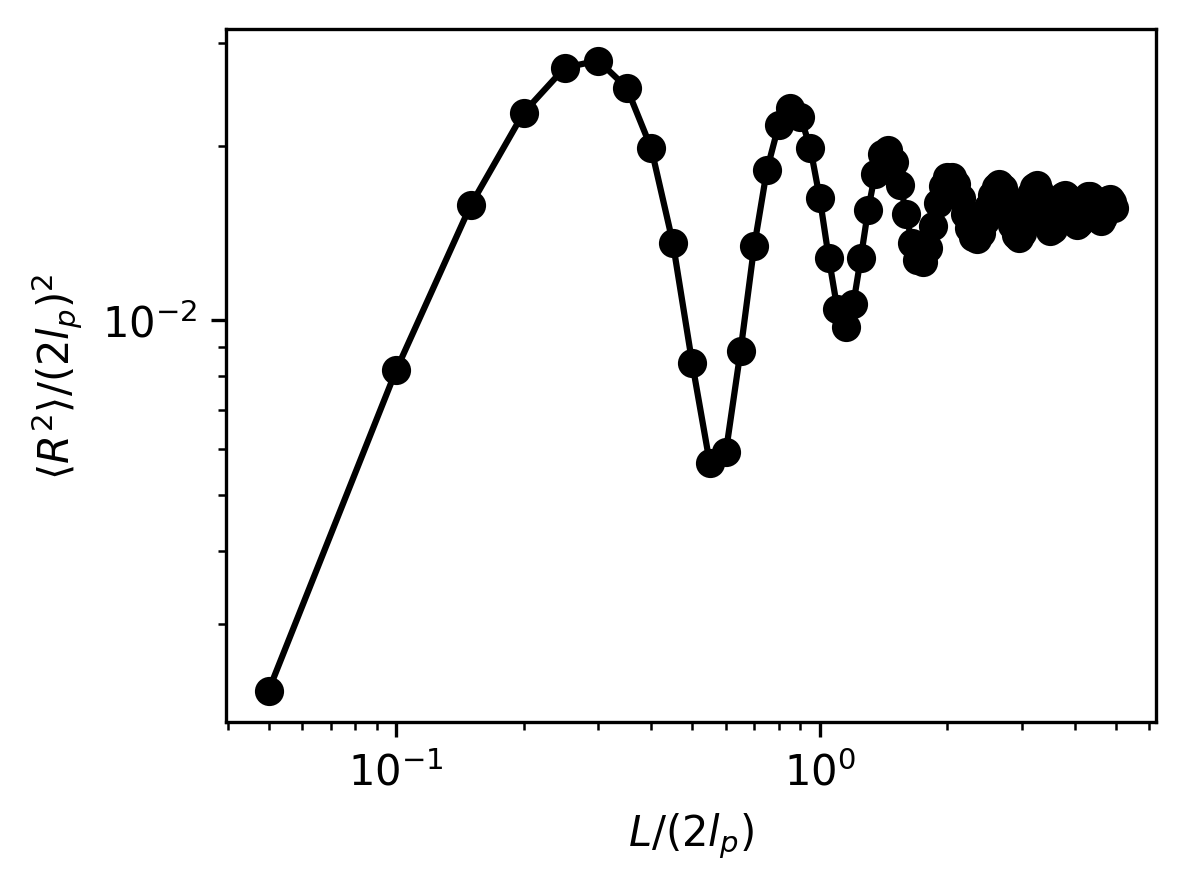

In [13]:
# Plot the non-dimensionalized mean-squared end-to-end distances
plt.figure(figsize=(4, 3), dpi=300)
plt.plot(kuhn_steps, mean_r2/((2 * lp)**2), "-o", color="black")
plt.xlabel(r"$L/(2l_p)$")
plt.ylabel(r"$\langle R^2 \rangle / (2l_p)^2$")
plt.xscale("log")
plt.yscale("log")
plt.show()

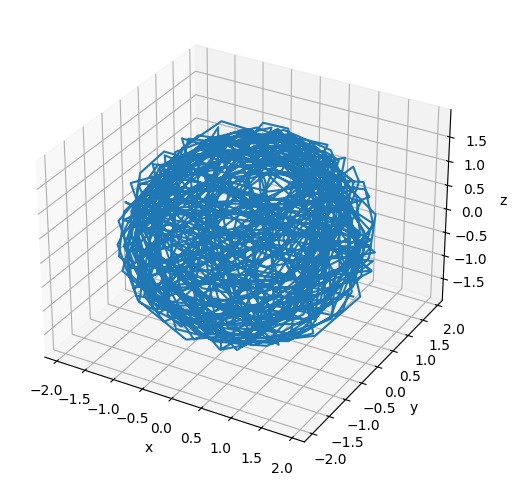

In [14]:
# Plot the final configuration of the polymer
x = polymers[0].r[:, 0]
y = polymers[0].r[:, 1]
z = polymers[0].r[:, 2]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.plot3D(np.asarray(x), np.asarray(y), np.asarray(z))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()